In [1]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np

In [2]:
class World:
    def __init__(self, time_span, time_interval, debug=False):
        self.objects = []
        self.debug = debug
        self.time_span = time_span
        self.time_interval = time_interval

    def append(self, obj):
        self.objects.append(obj)

    def draw(self):
        fig = plt.figure(figsize=(8, 2))
        ax = fig.add_subplot(111)
        ax.set_aspect('auto')
        ax.set_xlim(-5, 5)
        ax.set_ylim(-1, 1)  # 1次元なのでy軸は固定
        ax.set_xlabel("X", fontsize=10)
        ax.set_yticks([])  # y軸のラベルを非表示に

        elems = []

        if self.debug:
            for i in range(int(self.time_span / self.time_interval)):
                self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(
                fig, self.one_step, fargs=(elems, ax),
                frames=int(self.time_span / self.time_interval) + 1,
                interval=int(self.time_interval * 1000), repeat=False
            )
            plt.show()

    def one_step(self, i, elems, ax):
        while elems:
            elems.pop().remove()
        time_str = "t = %.2f[s]" % (self.time_interval * i)
        elems.append(ax.text(-4.8, 0.8, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"):
                obj.one_step(self.time_interval)


In [3]:
class IdealRobot:   
    def __init__(self, pose, agent=None, sensor=None, color="black"):
        self.pose = pose  # Only x-coordinate
        self.color = color 
        self.agent = agent
        self.poses = [pose]
        self.sensor = sensor

    def draw(self, ax, elems):
        x = self.pose  # 1D position
        elems += ax.plot(x, 0, marker="o", color=self.color, markersize=10)
        self.poses.append(self.pose)
        elems += ax.plot(self.poses, [0] * len(self.poses), linewidth=0.5, color="black")
        if self.sensor and len(self.poses) > 1:
            self.sensor.draw(ax, elems, self.poses[-2])
        if self.agent and hasattr(self.agent, "draw"):                               #以下2行追加   
            self.agent.draw(ax, elems)
            
    @classmethod
    def state_transition(cls, nu, time, x):
        return x + nu * time

    def one_step(self, time_interval):
        if not self.agent:
            return
        obs =self.sensor.data(self.pose) if self.sensor else None #追加
        nu = self.agent.decision(obs)
        self.pose = self.state_transition(nu, time_interval, self.pose)

In [4]:
class Agent:
    def __init__(self, nu):
        self.nu = nu

    def decision(self, observation=None):
        return self.nu

In [5]:
class Landmark:
    def __init__(self, x):
        self.pos = x
        self.id = None

    def draw(self, ax, elems):
        elems += ax.plot(self.pos, 0, marker="*", color="orange", markersize=15)
        elems.append(ax.text(self.pos, 0.2, "id:" + str(self.id), fontsize=10))

In [6]:
class Map:
    def __init__(self):
        self.landmarks = []

    def append_landmark(self, landmark):
        landmark.id = len(self.landmarks)
        self.landmarks.append(landmark)

    def draw(self, ax, elems):
        for lm in self.landmarks:
            lm.draw(ax, elems)

In [7]:
class IdealCamera:          
    def __init__(self, env_map, distance_range=(0.1, 1.0)):
        self.map = env_map
        self.lastdata = []     
        self.distance_range = distance_range
        
    def visible(self, distance):  # ランドマークが計測できる条件
        if distance is None:
            return False     
        return self.distance_range[0] <= distance <= self.distance_range[1]
        
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z  = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):
                observed.append((z, lm.id))
            
        self.lastdata = observed 
        return observed
    
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        diff = obj_pos - cam_pose
        return diff
    
    def draw(self, ax, elems, cam_pose): 
        for lm in self.lastdata:
            distance = lm[0]
#             lx = cam_pose + distance if distance > 0 else cam_pose - distance
            lx = cam_pose + distance
            elems += ax.plot([cam_pose, lx], [0, 0], color="pink")

<IPython.core.display.Javascript object>


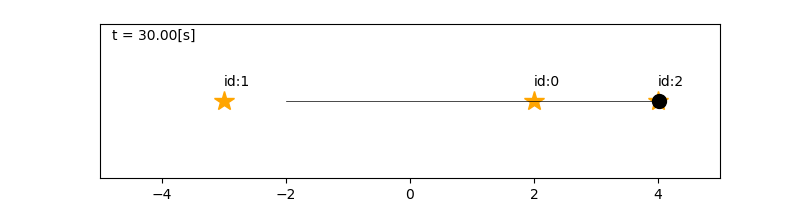

In [8]:
if __name__ == '__main__':
    world = World(30, 0.1) 

    m = Map()                                  
    m.append_landmark(Landmark(2))
    m.append_landmark(Landmark(-3))
    m.append_landmark(Landmark(4))
    world.append(m)          

    straight = Agent(0.2)    
    robot1 = IdealRobot(-2, sensor=IdealCamera(m), agent=straight)  
    world.append(robot1)

    world.draw()